# Plotting Cycle Based Features
-This notebook is for plotting cycle based features that were extracted in Processing notebook and stored as df_gen

-Note that df_gen as saved has not been filtered at all, all incomplete cycles are filtered explicitly here to keep track, and will be filtered in other notebooks when combining with other dataframes so that it's easy to track what's been removed

-Lengths here are in um (though always check what you're pulling from processing), times are in minutes, and rate is um/min (but will be plotted as um/hr most likely)

In [32]:
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import os
import re
from collections import defaultdict
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# makes figures look better in Jupyter
sns.set_context('talk')
sns.set_style("ticks")
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [33]:
plot_output = '/Volumes/salmonella/users/madison/2024_DIMM_MultirepAnalysis/LineagePlotting/Final_Plots'
df_gen = pd.read_csv(os.path.join(plot_output, 'df_gen.csv'))
df_gen

,Unnamed: 0,unique_ID,experiment,channel_width,last_valid_cell_time,first_valid_cell_time,position,track,cell_id,parent,cycle,start_time,start_length,end_time,end_length,cycle_duration,total_growth,avg_elong_rate
0,0,20240809__XY02_crop1__Track_17,20240809,1.3,1080,0,XY02_crop1,Track_17,1,0,0,0,3.548309,550,5.862985,550,2.314676,0.004209
1,1,20240809__XY02_crop1__Track_17,20240809,1.3,1080,0,XY02_crop1,Track_17,1,0,1,555,3.034881,945,5.603588,390,2.568707,0.006586
2,2,20240809__XY02_crop1__Track_17,20240809,1.3,1080,0,XY02_crop1,Track_17,1,0,2,950,3.291337,1080,3.825624,130,0.534287,0.004110
3,3,20240809__XY02_crop1__Track_17,20240809,1.3,1080,555,XY02_crop1,Track_17,2,1,0,555,3.015327,695,4.178241,140,1.162914,0.008307
4,4,20240809__XY02_crop1__Track_17,20240809,1.3,1080,555,XY02_crop1,Track_17,2,1,1,700,2.116246,975,4.082083,275,1.965836,0.007148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10217,10217,20241028__XY29_crop7__Track_9,20241028,1.2,1080,785,XY29_crop7,Track_9,4,1,0,785,2.397081,870,3.034881,85,0.637799,0.007504
10218,10218,20241028__XY29_crop7__Track_9,20241028,1.2,1080,785,XY29_crop7,Track_9,4,1,1,875,1.570796,1080,2.303606,205,0.732810,0.003575
10219,10219,20241028__XY29_crop7__Track_9,20241028,1.2,1080,875,XY29_crop7,Track_9,5,4,0,875,1.734416,1080,2.524143,205,0.789727,0.003852
10220,10220,20241028__XY29_crop7__Track_9,20241028,1.2,1080,910,XY29_crop7,Track_9,6,1,0,910,1.734416,1080,2.554095,170,0.819679,0.004822


In [80]:
#Filtering incomplete cycles
df_gen_no_end_cycle = df_gen[df_gen['end_time']!=1080] #removes incomplete cycles at the end of the expt

#Now remove cycles where cells fall out end of channel - defined as cycles that both don't have a following cycle and don't have valid cell IDs through the last time point
df_gen_no_end_cycle = df_gen_no_end_cycle.sort_values(by=['unique_ID', 'cell_id', 'cycle']) #sort
df_gen_no_end_cycle['next_cycle'] = df_gen_no_end_cycle.groupby(['unique_ID','cell_id'])['cycle'].shift(-1) #find following cycle
df_gen_no_lost_cells = df_gen_no_end_cycle[(df_gen_no_end_cycle['next_cycle'] == df_gen_no_end_cycle['cycle'] + 1) | (df_gen_no_end_cycle['last_valid_cell_time'] == 1080)].copy() #filter

#Remove first cycle as that's also incomplete
df_filtered = df_gen_no_lost_cells[df_gen_no_lost_cells['start_time']!=0]
df_filtered = df_filtered[df_filtered['cycle_duration']>=10]


print(len(df_gen))
print(len(df_gen_no_end_cycle))
print(len(df_gen_no_lost_cells))
print(len(df_filtered))

10222
6112
4983
4723


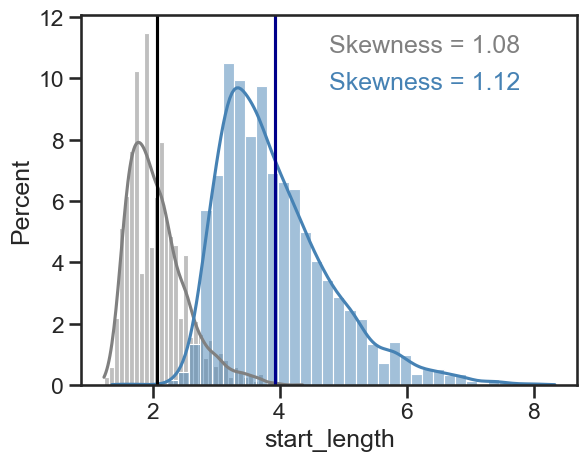

In [137]:
fig, ax = plt.subplots()
sns.histplot(data=df_filtered['start_length'], kde=True, bins = 40, ax=ax, color = 'gray', stat = 'percent')
start_length_skew = df_filtered['start_length'].skew()
sns.histplot(data=df_filtered['end_length'], kde=True, bins = 40, ax=ax, color = 'steelblue', stat = 'percent')
end_length_skew = df_filtered['end_length'].skew()
ax.annotate(f"Skewness = {start_length_skew:.2f}", xy=(0.5, 0.9), xycoords="axes fraction", color = 'grey')
ax.annotate(f"Skewness = {end_length_skew:.2f}", xy=(0.5, 0.8), xycoords="axes fraction", color = 'steelblue')
ax.axvline(x=df_filtered['end_length'].mean(), ls ='-', color='darkblue')
ax.axvline(x=df_filtered['start_length'].mean(), color = 'black', ls='-')
#ax.axvline(x=df_filtered['end_length'].std()+df_filtered['end_length'].mean(), color = 'steelblue', ls='--')
#ax.axvline(x=df_filtered['end_length'].mean()- df_filtered['end_length'].std(), color = 'steelblue', ls='--')
#ax.axvline(x=df_filtered['start_length'].std()+df_filtered['start_length'].mean(), color = 'grey', ls='--')
#ax.axvline(x=df_filtered['start_length'].mean()- df_filtered['start_length'].std(), color = 'grey', ls='--')
plt.savefig(plot_output+'/start_end_length_distribution.pdf')

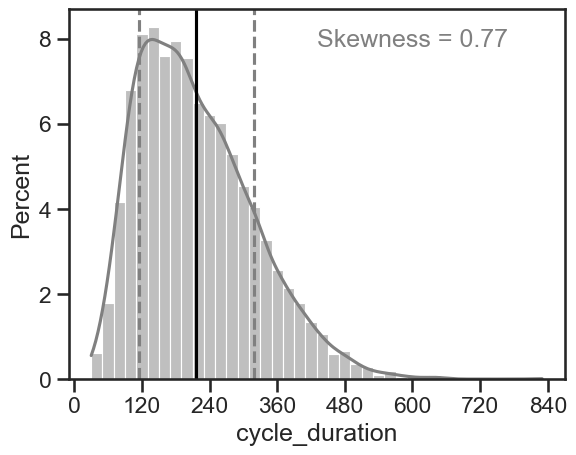

In [138]:
fig, ax = plt.subplots()
sns.histplot(data=df_filtered['cycle_duration'], kde=True, bins = 40, ax=ax, color = 'gray', stat = 'percent')
dur_skew = df_filtered['cycle_duration'].skew()
ax.annotate(f"Skewness = {dur_skew:.2f}", xy=(0.5, 0.9), xycoords="axes fraction", color = 'grey')
ax.axvline(x=df_filtered['cycle_duration'].mean(), color = 'black', ls='-')
ax.axvline(x=df_filtered['cycle_duration'].std()+df_filtered['cycle_duration'].mean(), color = 'grey', ls='--')
ax.axvline(x=df_filtered['cycle_duration'].mean()- df_filtered['cycle_duration'].std(), color = 'grey', ls='--')
ax.set_xticks([0, 120, 240, 360, 480, 600, 720, 840])
plt.savefig(plot_output+'/cycle_duration.pdf')

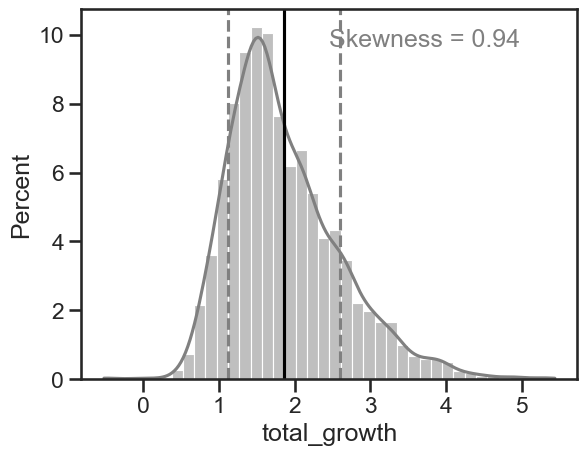

In [133]:
fig, ax = plt.subplots()
sns.histplot(data=df_filtered['total_growth'], kde=True, bins = 40, ax=ax, color = 'gray', stat = 'percent')
dur_skew = df_filtered['total_growth'].skew()
ax.annotate(f"Skewness = {dur_skew:.2f}", xy=(0.5, 0.9), xycoords="axes fraction", color = 'grey')
ax.axvline(x=df_filtered['total_growth'].mean(), color = 'black', ls='-')
ax.axvline(x=df_filtered['total_growth'].std()+df_filtered['total_growth'].mean(), color = 'grey', ls='--')
ax.axvline(x=df_filtered['total_growth'].mean()- df_filtered['total_growth'].std(), color = 'grey', ls='--')
plt.savefig(plot_output+'/total_growth.pdf')

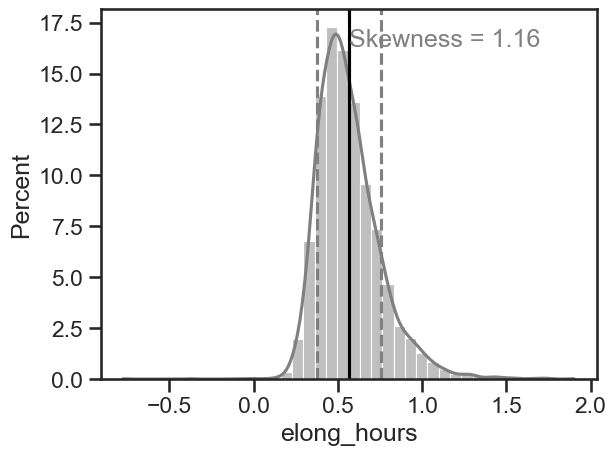

In [131]:
fig, ax = plt.subplots()
df_filtered['elong_hours']=df_filtered['avg_elong_rate']*60
sns.histplot(data=df_filtered['elong_hours'], kde=True, bins = 40, ax=ax, color = 'gray', stat = 'percent')
dur_skew = df_filtered['elong_hours'].skew()
ax.annotate(f"Skewness = {dur_skew:.2f}", xy=(0.5, 0.9), xycoords="axes fraction", color = 'grey')
ax.axvline(x=df_filtered['elong_hours'].mean(), color = 'black', ls='-')
ax.axvline(x=df_filtered['elong_hours'].std()+df_filtered['elong_hours'].mean(), color = 'grey', ls='--')
ax.axvline(x=df_filtered['elong_hours'].mean()- df_filtered['elong_hours'].std(), color = 'grey', ls='--')
plt.savefig(plot_output+'/elong_rate.pdf')

In [118]:
df_gen_mothers = df_gen[df_gen['parent']==0]
df_gen_mothers

,Unnamed: 0,unique_ID,experiment,channel_width,last_valid_cell_time,first_valid_cell_time,position,track,cell_id,parent,cycle,start_time,start_length,end_time,end_length,cycle_duration,total_growth,avg_elong_rate
0,0,20240809__XY02_crop1__Track_17,20240809,1.3,1080,0,XY02_crop1,Track_17,1,0,0,0,3.548309,550,5.862985,550,2.314676,0.004209
1,1,20240809__XY02_crop1__Track_17,20240809,1.3,1080,0,XY02_crop1,Track_17,1,0,1,555,3.034881,945,5.603588,390,2.568707,0.006586
2,2,20240809__XY02_crop1__Track_17,20240809,1.3,1080,0,XY02_crop1,Track_17,1,0,2,950,3.291337,1080,3.825624,130,0.534287,0.004110
9,9,20240809__XY02_crop2__Track_20,20240809,1.3,1080,0,XY02_crop2,Track_20,1,0,0,0,1.988618,535,3.260383,535,1.271766,0.002377
10,10,20240809__XY02_crop2__Track_20,20240809,1.3,1080,0,XY02_crop2,Track_20,1,0,1,540,1.861317,1070,5.756813,530,3.895496,0.007350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10167,10167,20241028__XY29_crop6__Track_3,20241028,1.2,1080,0,XY29_crop6,Track_3,1,0,3,690,2.779082,1080,5.331585,390,2.552503,0.006545
10209,10209,20241028__XY29_crop7__Track_9,20241028,1.2,1080,0,XY29_crop7,Track_9,1,0,0,0,2.372277,235,3.519616,235,1.147339,0.004882
10210,10210,20241028__XY29_crop7__Track_9,20241028,1.2,1080,0,XY29_crop7,Track_9,1,0,1,240,1.932589,780,5.336338,540,3.403749,0.006303
10211,10211,20241028__XY29_crop7__Track_9,20241028,1.2,1080,0,XY29_crop7,Track_9,1,0,2,785,3.034881,905,4.192374,120,1.157493,0.009646


In [119]:
df_count = df_gen_mothers.groupby('unique_ID').size().reset_index(name='div_count')
df_count

,unique_ID,div_count
0,20240809__XY01_crop3__Track_5,3
1,20240809__XY02_crop1__Track_17,3
2,20240809__XY02_crop2__Track_20,3
3,20240809__XY02_crop3__Track_8,4
4,20240809__XY03_crop1__Track_61,4
...,...,...
251,20241028__XY29_crop3__Track_4,5
252,20241028__XY29_crop4__Track_18,3
253,20241028__XY29_crop5__Track_6,4
254,20241028__XY29_crop6__Track_3,4


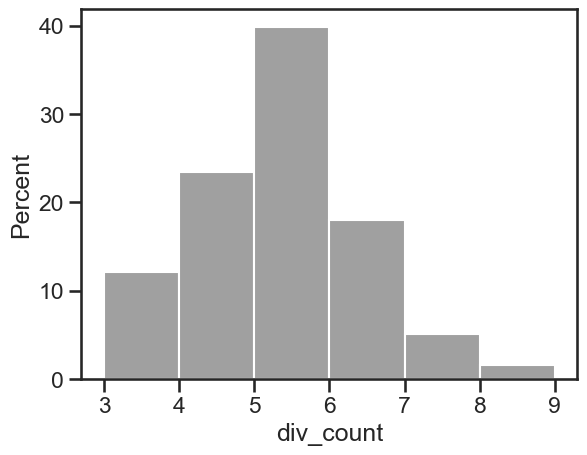

In [130]:
sns.histplot(data = df_count, x='div_count', color = 'gray', binwidth=1, stat = 'percent')
plt.savefig(plot_output+'/mother_divisions.pdf')

In [165]:
cell_count_df = (df_gen.groupby('unique_ID')['cell_id'].nunique()
    .reset_index()
    .rename(columns={'cell_id': 'cell_count'}))
cell_count_df_sorted = cell_count_df.sort_values(by='cell_count')
cell_count_df_sorted['fraction_total'] = cell_count_df_sorted['cell_count']/cell_count_df_sorted['cell_count'].sum()


<Axes: xlabel='cell_count', ylabel='fraction_total'>

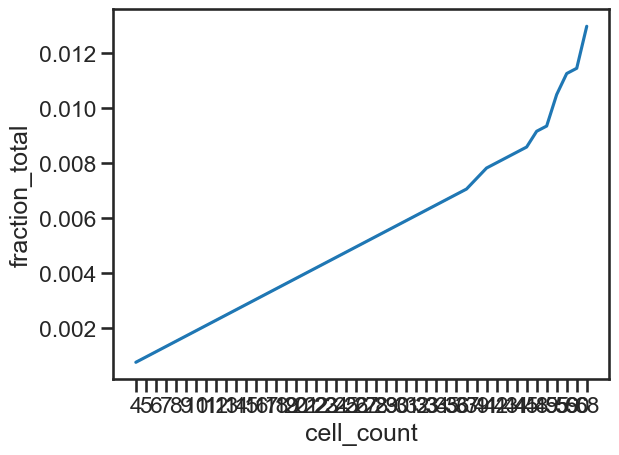

In [164]:

sns.lineplot(data=cell_count_df_sorted, x='cell_count', y='fraction_total')

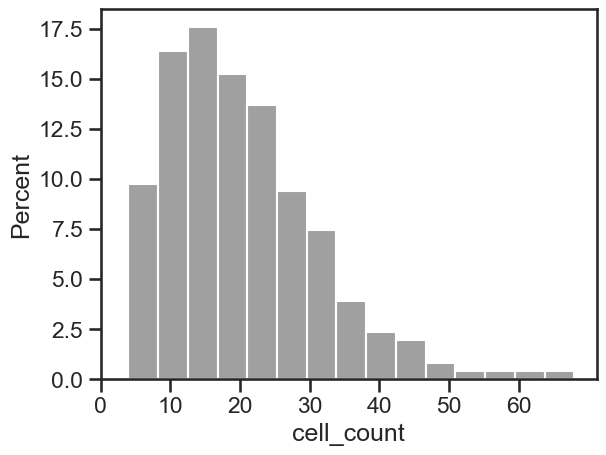

In [173]:
fig, ax = plt.subplots()
sns.histplot(data=cell_count_df_sorted, x='cell_count', color='gray', stat = 'percent', ax=ax)
ax.set_xticks([0, 10, 20, 30, 40, 50, 60])
#ax.axvline(x=cell_count_df_sorted['cell_count'].mean(), color = 'black', ls='-')
plt.savefig(plot_output+'/total_cell_count.pdf')